In [ ]:
!pip install transformers datasets evaluate sentencepiece rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 560.8 kB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=64441a994b0225093bdc8cec7905b4ad785d5607d37794d2d365c0b56a7d435e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
from google.colab import files

import pandas as pd

# Cargar Dataset A (simplificación)
df_a = pd.read_excel('simplificacion.xlsx', usecols=["Segmento", "Propuesta"])

# Ver cuántos ejemplos hay
print(f"Tamaño Dataset A: {len(df_a)}")
df_a.head()

df_a["prefix"] = "simplify: "
df_a["input_text"] = df_a["prefix"] + df_a["Segmento"]
df_a["target_text"] = df_a["Propuesta"]

from sklearn.model_selection import train_test_split

df_a_train, df_a_test = train_test_split(df_a, test_size=0.2, random_state=42)

print(f"Train A: {len(df_a_train)}, Test A: {len(df_a_test)}")






# Cargar Dataset B (traducción)
df_b = pd.read_excel('traduccion.xlsx', usecols=["Segmento", "Propuesta"])

print(f"Tamaño Dataset B: {len(df_b)}")
df_b.head()


# LIMPIAR
# Eliminar filas donde Propuesta es float
df_b = df_b[df_b["Propuesta"].apply(lambda x: isinstance(x, str))]

# Dropear posibles NaN
df_b = df_b.dropna(subset=["Segmento", "Propuesta"])

# Asegurar que todo es string
df_b["Segmento"] = df_b["Segmento"].astype(str)
df_b["Propuesta"] = df_b["Propuesta"].astype(str)


df_b["prefix"] = "translate"
df_b["input_text"] = df_b["prefix"] + df_b["Segmento"]
df_b["target_text"] = df_b["Propuesta"]

df_b_train, df_b_test = train_test_split(df_b, test_size=0.2, random_state=42)

print(f"Train B: {len(df_b_train)}, Test B: {len(df_b_test)}")

Tamaño Dataset A: 5313
Train A: 4250, Test A: 1063
Tamaño Dataset B: 5313
Train B: 4246, Test B: 1062


In [ ]:
from torch.utils.data import Dataset
import torch

class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input_text = self.dataframe.iloc[idx]["input_text"]
        target_text = self.dataframe.iloc[idx]["target_text"]

        input_enc = self.tokenizer(
            input_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        target_enc = self.tokenizer(
            target_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze()
        }

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

train_dataset_a = TextDataset(df_a_train, tokenizer)
test_dataset_a = TextDataset(df_a_test, tokenizer)

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results_A',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_dir='./logs_A',
    logging_steps=10,
    learning_rate=5e-4,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_a,
    eval_dataset=test_dataset_a
)

trainer.train()

# Guardar el modelo
model.save_pretrained("./model_after_A")
tokenizer.save_pretrained("./model_after_A")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,3.004600
20,0.646800
30,0.708600
40,0.569000
50,0.524800
60,0.601200
70,0.595500
80,0.585700
90,0.506600
100,0.549800


('./model_after_A/tokenizer_config.json',
 './model_after_A/special_tokens_map.json',
 './model_after_A/spiece.model',
 './model_after_A/added_tokens.json')

In [ ]:
import pandas as pd
# Lista para almacenar ejemplos
examples_manual = []

device = "cuda" if torch.cuda.is_available() else "cpu"


# Mover el modelo a device
model.to(device)

def simplify_text(text):
    input_text = "simplify: " + text
    input_enc = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=128).to(device)
    output = model.generate(input_enc, max_length=128)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generar ejemplos
for idx in range(5):  # o 10, lo que quieras
    original_text = df_a_test.iloc[idx]["Segmento"]
    target_text = df_a_test.iloc[idx]["Propuesta"]
    prediction = simplify_text(original_text)

    input_text = "simplify: " + original_text

    # Guardar ejemplo como dict
    examples_manual.append({
        "N°": idx+1,
        "Input (prefix + texto)": input_text,
        "Target": target_text,
        "Prediction": prediction
    })

    # También imprimir por consola (opcional)
    print(f"Ejemplo {idx+1}")
    print("Input:", input_text)
    print("Target:", target_text)
    print("Prediction:", prediction)
    print("-" * 80)



Ejemplo 1
Input: simplify: Aunque parezca extraño, es posible que un bien pueda ser útil en una circunstancia y no en otra.
Target: Es posible que un bien sea útil en una circunstancia y otra en otra no.
Prediction: Aunque parezca extrao es un bien pueda ser til en una circunstancia y no en otra.
--------------------------------------------------------------------------------
Ejemplo 2
Input: simplify: Antes de elaborar un presupuesto, como previamente lo señalamos, que implica necesariamente referirse al factor dinero, hay que trabajar en lo que algunos autores denominan Planeación de Vida.
Target: Antes de elaborar un presupuesto que implica necesariamente referirse al factor dinero, hay que trabajar en lo que algunos autores denominan Planeación de Vida.
Prediction: Antes de elaborar un presupuesto, como previamente lo sealamos, que implica necesariamente referirse al factor dinero, hay que trabajar en lo que algunos autores denominan Planeación de Vida.
----------------------------

In [ ]:
import evaluate
rouge = evaluate.load("rouge")

# Crear listas de predictions y references
predictions = []
references = []

for i in range(len(df_a_test)):
    input_text = df_a_test.iloc[i]["Segmento"]
    target_text = df_a_test.iloc[i]["Propuesta"]

    pred_text = simplify_text(input_text)

    predictions.append(pred_text)
    references.append(target_text)

# Calcular ROUGE
results = rouge.compute(predictions=predictions, references=references)

print(results)

bleu = evaluate.load("bleu")

# BLEU espera referencias como listas de listas
references_bleu = [[ref] for ref in references]

results_bleu = bleu.compute(predictions=predictions, references=references_bleu)

print(results_bleu)

import pandas as pd

# Crear DataFrame con las métricas
df_metrics = pd.DataFrame({
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum", "BLEU"],
    "Score": [
        results["rouge1"],
        results["rouge2"],
        results["rougeL"],
        results["rougeLsum"],
        results_bleu["bleu"]
    ]
})

# Mostrar la tabla
df_metrics

{'rouge1': np.float64(0.6876856585071036), 'rouge2': np.float64(0.5234879717022495), 'rougeL': np.float64(0.6468557989764787), 'rougeLsum': np.float64(0.6467322213407053)}


{'bleu': 0.4292240683743511, 'precisions': [0.6530051721062957, 0.4764941420732612, 0.3713767416727778, 0.29372937293729373], 'brevity_penalty': 1.0, 'length_ratio': 1.0781448294427567, 'translation_length': 28035, 'reference_length': 26003}


,Metric,Score
0,ROUGE-1,0.687686
1,ROUGE-2,0.523488
2,ROUGE-L,0.646856
3,ROUGE-Lsum,0.646732
4,BLEU,0.429224


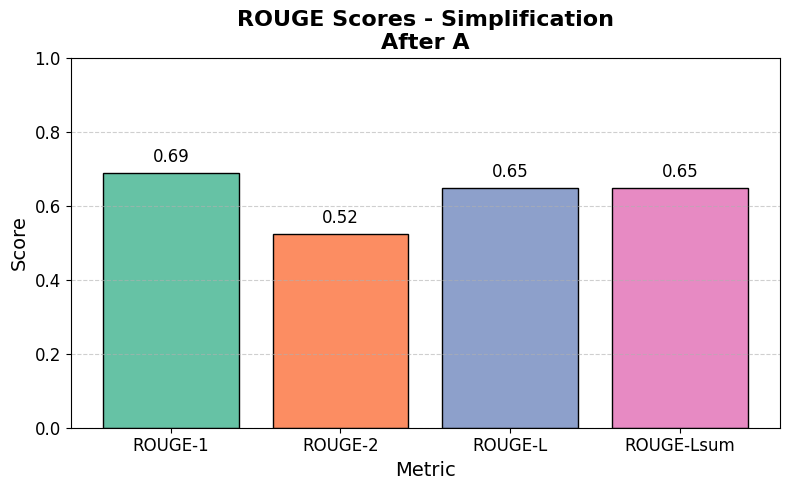

In [ ]:
import matplotlib.pyplot as plt

# Filtrar solo métricas ROUGE
df_rouge_metrics = df_metrics[df_metrics["Metric"].str.contains("ROUGE")]

# Configuración de estilo bonito
plt.figure(figsize=(8, 5))
bars = plt.bar(df_rouge_metrics["Metric"], df_rouge_metrics["Score"],
               color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], edgecolor='black')

# Agregar valores arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', va='bottom', fontsize=12)

# Estética del gráfico
plt.ylim(0, 1)
plt.title("ROUGE Scores - Simplification\nAfter A", fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajustar layout para que no se corte nada
plt.tight_layout()

# Mostrar
plt.show()

In [ ]:
train_dataset_b = TextDataset(df_b_train, tokenizer)
test_dataset_b = TextDataset(df_b_test, tokenizer)

model = T5ForConditionalGeneration.from_pretrained("./model_after_A")
tokenizer = T5Tokenizer.from_pretrained("./model_after_A")

# mover a device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

training_args = TrainingArguments(
    output_dir='./results_B_noCL',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_dir='./logs_B_noCL',
    logging_steps=10,
    learning_rate=5e-4,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_b,
    eval_dataset=test_dataset_b
)

trainer.train()

# Guardar modelo after B no CL
model.save_pretrained("./model_after_B_noCL")
tokenizer.save_pretrained("./model_after_B_noCL")

Step,Training Loss
10,0.951500
20,0.788200
30,0.731700
40,0.746600
50,0.649100
60,0.677000
70,0.695200
80,0.660100
90,0.672100
100,0.683100


('./model_after_B_noCL/tokenizer_config.json',
 './model_after_B_noCL/special_tokens_map.json',
 './model_after_B_noCL/spiece.model',
 './model_after_B_noCL/added_tokens.json')

In [ ]:
def run_model(text, prefix):
    input_text = prefix + text
    input_enc = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=128).to(device)
    output = model.generate(input_enc, max_length=128)
    return tokenizer.decode(output[0], skip_special_tokens=True), input_text

model = T5ForConditionalGeneration.from_pretrained("./model_after_B_noCL")
tokenizer = T5Tokenizer.from_pretrained("./model_after_B_noCL")

# mover a device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for idx in range(5):
    original_text = df_b_test.iloc[idx]["Segmento"]
    target_text = df_b_test.iloc[idx]["Propuesta"]
    prediction = run_model(original_text, "translate: ")

    prediction_text, model_input = run_model(original_text, "translate: ")  # ojo, tu prefix debería ser este!

    print(f"Ejemplo {idx+1} - Translation")
    print("Input:", model_input)  # opcional, podés mostrarlo si querés
    print("Target (translation):", target_text)
    print("Prediction:", prediction_text)
    print("-" * 80)

Ejemplo 1 - Translation
Input: translate: Las operaciones financieras incluyen intereses debido a un principio básico del dinero: un dólar hoy es preferible a un dólar mañana.
Target (translation): Financial transactions include interest due to a basic principle of money: a dollar today is preferable to a dollar tomorrow.
Prediction: Financial operations include interest based on a basic principle of money: a dollar today is preferable to a dollar.
--------------------------------------------------------------------------------
Ejemplo 2 - Translation
Input: translate: Para el mes siguiente, haz una lista de los gastos que efectivamente hiciste.
Target (translation): For the following month, make a list of the expenses you actually made.
Prediction: For the next month, hazard a list of the expenses that are effectively made.
--------------------------------------------------------------------------------
Ejemplo 3 - Translation
Input: translate: Se paga al fisco en el primer cuatrimest

In [ ]:


for idx in range(30):
    original_text = df_a_test.iloc[idx]["Segmento"]
    target_text = df_a_test.iloc[idx]["Propuesta"]
    prediction, model_input = run_model(original_text, "simplify: ")

    print(f"Ejemplo {idx+1} - Simplificación")
    print("Input:", model_input)  # <- aquí ves el input exacto
    print("Target (simplification):", target_text)
    print("Prediction:", prediction)
    print("-" * 80)

Ejemplo 1 - Simplificación
Input: simplify: Aunque parezca extraño, es posible que un bien pueda ser útil en una circunstancia y no en otra.
Target (simplification): Es posible que un bien sea útil en una circunstancia y otra en otra no.
Prediction: Even though it is fairly extra, it is possible that a good can be useful in a circumstance and not in another.
--------------------------------------------------------------------------------
Ejemplo 2 - Simplificación
Input: simplify: Antes de elaborar un presupuesto, como previamente lo señalamos, que implica necesariamente referirse al factor dinero, hay que trabajar en lo que algunos autores denominan Planeación de Vida.
Target (simplification): Antes de elaborar un presupuesto que implica necesariamente referirse al factor dinero, hay que trabajar en lo que algunos autores denominan Planeación de Vida.
Prediction: Before preparing a budget, as we previously pointed out, which implies necessary reference to the money factor, it must wor

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("./model_after_B_noCL")
tokenizer = T5Tokenizer.from_pretrained("./model_after_B_noCL")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def run_model(text, prefix):
    input_text = prefix + text
    input_enc = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=128).to(device)
    output = model.generate(input_enc, max_length=128)
    return tokenizer.decode(output[0], skip_special_tokens=True), input_text

import evaluate

rouge = evaluate.load("rouge")

predictions_a = []
references_a = []

for i in range(len(df_a_test)):
    original_text = df_a_test.iloc[i]["Segmento"]
    target_text = df_a_test.iloc[i]["Propuesta"]

    prediction_text, model_input = run_model(original_text, "simplify: ")

    predictions_a.append(prediction_text)
    references_a.append(target_text)

# Calcular ROUGE
results_rouge_a_afterBnoCL = rouge.compute(predictions=predictions_a, references=references_a)

# Mostrar resultados
print(results_rouge_a_afterBnoCL)

# (Opcional) Guardarlo en DataFrame para que te quede ordenado
import pandas as pd

df_metrics_afterBnoCL_testA = pd.DataFrame({
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"],
    "Score": [
        results_rouge_a_afterBnoCL["rouge1"],
        results_rouge_a_afterBnoCL["rouge2"],
        results_rouge_a_afterBnoCL["rougeL"],
        results_rouge_a_afterBnoCL["rougeLsum"]
    ]
})

# Mostrar tabla
df_metrics_afterBnoCL_testA

# (Opcional) Exportar
df_metrics_afterBnoCL_testA.to_csv("metrics_afterBnoCL_testA.csv", index=False)

{'rouge1': np.float64(0.027653975161926338), 'rouge2': np.float64(0.0016399929938283075), 'rougeL': np.float64(0.026472958358473124), 'rougeLsum': np.float64(0.026498258870964263)}


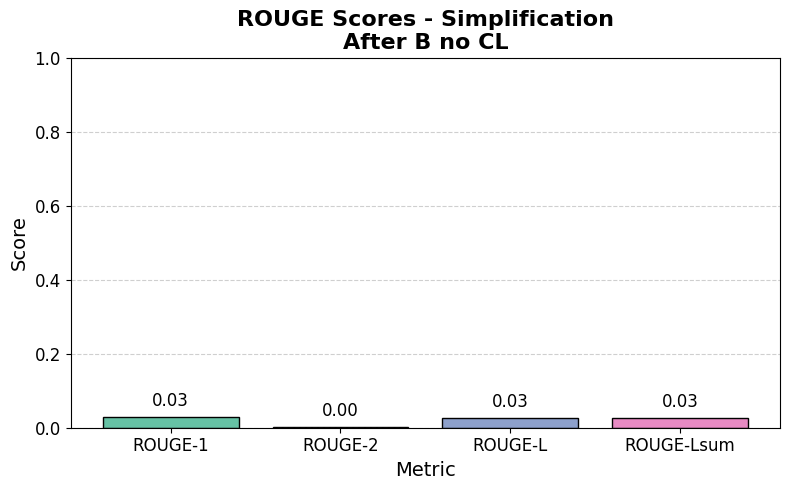

In [ ]:
import pandas as pd

# Tabla ordenada de ROUGE → con nombres claros
df_metrics_afterBnoCL_testA = pd.DataFrame({
    "Métrica": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"],
    "Valor": [
        round(results_rouge_a_afterBnoCL["rouge1"], 4),
        round(results_rouge_a_afterBnoCL["rouge2"], 4),
        round(results_rouge_a_afterBnoCL["rougeL"], 4),
        round(results_rouge_a_afterBnoCL["rougeLsum"], 4)
    ]
})

# Mostrar la tabla
df_metrics_afterBnoCL_testA




import matplotlib.pyplot as plt

# Gráfico bonito para ROUGE After B no CL → Test A
plt.figure(figsize=(8, 5))
bars = plt.bar(df_metrics_afterBnoCL_testA["Métrica"], df_metrics_afterBnoCL_testA["Valor"],
               color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], edgecolor='black')

# Agregar valores arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', va='bottom', fontsize=12)

# Estética del gráfico
plt.ylim(0, 1)
plt.title("ROUGE Scores - Simplification\nAfter B no CL", fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajustar layout para que no se corte nada
plt.tight_layout()

# Mostrar
plt.show()

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("./model_after_B_noCL")
tokenizer = T5Tokenizer.from_pretrained("./model_after_B_noCL")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def run_model(text, prefix):
    input_text = prefix + text
    input_enc = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=128).to(device)
    output = model.generate(input_enc, max_length=128)
    return tokenizer.decode(output[0], skip_special_tokens=True), input_text

import evaluate

# Cargar métrica BLEU
bleu = evaluate.load("bleu")

# Preparar listas
predictions_b = []
references_b = []

# Recorrer Test B
for i in range(len(df_b_test)):
    original_text = df_b_test.iloc[i]["Segmento"]
    target_text = df_b_test.iloc[i]["Propuesta"]

    # OJO → Usamos el prefix correcto
    prediction_text, model_input = run_model(original_text, "translate: ")

    predictions_b.append(prediction_text)
    references_b.append(target_text)

# BLEU espera referencias como listas de listas
references_bleu_b = [[ref] for ref in references_b]

# Calcular BLEU
results_bleu_b_afterBnoCL = bleu.compute(predictions=predictions_b, references=references_bleu_b)

# Mostrar resultados
print(results_bleu_b_afterBnoCL)

# (Opcional) Guardar tabla ordenada → para el paper
df_bleu_afterBnoCL_testB = pd.DataFrame({
    "Métrica": ["BLEU"],
    "Valor": [round(results_bleu_b_afterBnoCL["bleu"], 4)]
})

# Mostrar la tabla
df_bleu_afterBnoCL_testB



{'bleu': 0.42821686643436235, 'precisions': [0.7070900200601805, 0.4916996303741651, 0.36621893888515783, 0.2786405738561181], 'brevity_penalty': 0.9866743376301492, 'length_ratio': 0.9867623407150811, 'translation_length': 31904, 'reference_length': 32332}


,Métrica,Valor
0,BLEU,0.4282


CONTINUAL LEARNING CL

In [ ]:
# Asegurarse que Segmento y Propuesta sean str
df_a_train["Segmento"] = df_a_train["Segmento"].astype(str)
df_a_train["Propuesta"] = df_a_train["Propuesta"].astype(str)

# Preparar columnas
df_a_train["prefix"] = "simplify: "
df_a_train["input_text"] = df_a_train["prefix"] + df_a_train["Segmento"]
df_a_train["target_text"] = df_a_train["Propuesta"]


# Asegurarse que Segmento y Propuesta sean str
df_b_train["Segmento"] = df_b_train["Segmento"].astype(str)
df_b_train["Propuesta"] = df_b_train["Propuesta"].astype(str)

# Preparar columnas
df_b_train["prefix"] = "translate: "
df_b_train["input_text"] = df_b_train["prefix"] + df_b_train["Segmento"]
df_b_train["target_text"] = df_b_train["Propuesta"]

print(df_a_train[["input_text", "target_text"]].head(3))
print(df_b_train[["input_text", "target_text"]].head(3))

# Tomar 50% de A para replay
df_a_replay = df_a_train.sample(frac=0.5, random_state=42)

# Concatenar A + B
df_replay = pd.concat([df_a_replay, df_b_train]).reset_index(drop=True)

# Mezclar aleatoriamente
df_replay = df_replay.sample(frac=1.0, random_state=42).reset_index(drop=True)


                                             input_text  \
2778  simplify: Con el tiempo, es posible que termin...   
5020  simplify: La rotación de ventas es uno de los ...   
567   simplify: No obstante, lo negativo de esta for...   

                                            target_text  
2778  Con el tiempo, pagará más intereses que el mon...  
5020  La rotación de ventas es un indicador. Combina...  
567   No obstante, lo negativo de este control de la...  
                                             input_text  \
4403  translate: Este intermediario proporcionará a ...   
2985  translate: Si invirtieras toda tu riqueza en l...   
720   translate: La inversión en el campo productivo...   

                                            target_text  
4403  This intermediary will provide the company wit...  
2985  If you invested all your wealth in the shares ...  
720   Investment in the productive or business field...  


In [ ]:
#Entrenar modelo

train_dataset_replay = TextDataset(df_replay, tokenizer)

model = T5ForConditionalGeneration.from_pretrained("./model_after_A")
tokenizer = T5Tokenizer.from_pretrained("./model_after_A")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

training_args = TrainingArguments(
    output_dir='./results_B_withCL',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_dir='./logs_B_withCL',
    logging_steps=10,
    learning_rate=5e-4,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_replay,
    eval_dataset=test_dataset_a
)

trainer.train()

model.save_pretrained("./model_after_B_withCL")
tokenizer.save_pretrained("./model_after_B_withCL")

Step,Training Loss
10,0.830700
20,0.519500
30,0.679000
40,0.638500
50,0.607000
60,0.510100
70,0.512300
80,0.513200
90,0.554800
100,0.613400


('./model_after_B_withCL/tokenizer_config.json',
 './model_after_B_withCL/special_tokens_map.json',
 './model_after_B_withCL/spiece.model',
 './model_after_B_withCL/added_tokens.json')

In [ ]:
#Imprimir ejemplos de simplificación

model = T5ForConditionalGeneration.from_pretrained("./model_after_B_withCL")
tokenizer = T5Tokenizer.from_pretrained("./model_after_B_withCL")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def run_model(text, prefix):
    input_text = prefix + text
    input_enc = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=128).to(device)
    output = model.generate(input_enc, max_length=128)
    return tokenizer.decode(output[0], skip_special_tokens=True), input_text


for idx in range(20):
    original_text = df_a_test.iloc[idx]["Segmento"]
    target_text = df_a_test.iloc[idx]["Propuesta"]
    prediction, model_input = run_model(original_text, "simplify: ")

    print(f"Ejemplo {idx+1} - Simplificación")
    print("Input:", model_input)
    print("Target (simplification):", target_text)
    print("Prediction:", prediction)
    print("-" * 80)




Ejemplo 1 - Simplificación
Input: simplify: Aunque parezca extraño, es posible que un bien pueda ser útil en una circunstancia y no en otra.
Target (simplification): Es posible que un bien sea útil en una circunstancia y otra en otra no.
Prediction: Aunque parezca extrao, es posible que un bien pueda ser til en una circunstancia y no en otra.
--------------------------------------------------------------------------------
Ejemplo 2 - Simplificación
Input: simplify: Antes de elaborar un presupuesto, como previamente lo señalamos, que implica necesariamente referirse al factor dinero, hay que trabajar en lo que algunos autores denominan Planeación de Vida.
Target (simplification): Antes de elaborar un presupuesto que implica necesariamente referirse al factor dinero, hay que trabajar en lo que algunos autores denominan Planeación de Vida.
Prediction: Antes de elaborar un presupuesto que implica necesariamente referirse al factor dinero, hay que trabajar en lo que algunos autores denomina

In [ ]:
# Probar traducción manualmente (Test B)

for idx in range(20):
    original_text = df_b_test.iloc[idx]["Segmento"]
    target_text = df_b_test.iloc[idx]["Propuesta"]
    prediction, model_input = run_model(original_text, "translate: ")

    print(f"Ejemplo {idx+1} - Traducción")
    print("Input:", model_input)  # <- aquí ves el input exacto
    print("Target (translation):", target_text)
    print("Prediction:", prediction)
    print("-" * 80)

Ejemplo 1 - Traducción
Input: translate: Las operaciones financieras incluyen intereses debido a un principio básico del dinero: un dólar hoy es preferible a un dólar mañana.
Target (translation): Financial transactions include interest due to a basic principle of money: a dollar today is preferable to a dollar tomorrow.
Prediction: Financial operations include interest due to a basic principle of money: a dollar is now preferable to a dollar.
--------------------------------------------------------------------------------
Ejemplo 2 - Traducción
Input: translate: Para el mes siguiente, haz una lista de los gastos que efectivamente hiciste.
Target (translation): For the following month, make a list of the expenses you actually made.
Prediction: For the next month, you have a list of the expenses you effectively make.
--------------------------------------------------------------------------------
Ejemplo 3 - Traducción
Input: translate: Se paga al fisco en el primer cuatrimestre del año

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("./model_after_B_withCL")
tokenizer = T5Tokenizer.from_pretrained("./model_after_B_withCL")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


rouge = evaluate.load("rouge")

predictions_a_withCL = []
references_a_withCL = []

for i in range(len(df_a_test)):
    original_text = df_a_test.iloc[i]["Segmento"]
    target_text = df_a_test.iloc[i]["Propuesta"]

    prediction_text, model_input = run_model(original_text, "simplify: ")

    predictions_a_withCL.append(prediction_text)
    references_a_withCL.append(target_text)

# Calcular ROUGE
results_rouge_a_withCL = rouge.compute(predictions=predictions_a_withCL, references=references_a_withCL)

# Tabla ordenada
df_metrics_afterBwithCL_testA = pd.DataFrame({
    "Métrica": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"],
    "Valor": [
        round(results_rouge_a_withCL["rouge1"], 4),
        round(results_rouge_a_withCL["rouge2"], 4),
        round(results_rouge_a_withCL["rougeL"], 4),
        round(results_rouge_a_withCL["rougeLsum"], 4)
    ]
})


df_metrics_afterBwithCL_testA

,Métrica,Valor
0,ROUGE-1,0.7041
1,ROUGE-2,0.5472
2,ROUGE-L,0.6645
3,ROUGE-Lsum,0.6648


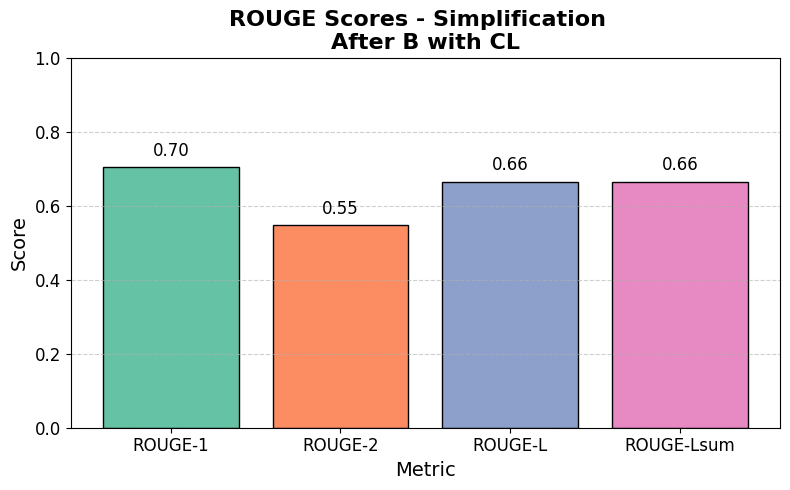

In [ ]:
import matplotlib.pyplot as plt

# Gráfico bonito para ROUGE After B with CL → Test A
plt.figure(figsize=(8, 5))
bars = plt.bar(df_metrics_afterBwithCL_testA["Métrica"], df_metrics_afterBwithCL_testA["Valor"],
               color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'], edgecolor='black')

# Agregar valores arriba de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2f}", ha='center', va='bottom', fontsize=12)

# Estética del gráfico
plt.ylim(0, 1)
plt.title("ROUGE Scores - Simplification  \nAfter B with CL", fontsize=16, fontweight='bold')
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Ajustar layout para que no se corte nada
plt.tight_layout()

# Mostrar
plt.show()

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("./model_after_B_withCL")
tokenizer = T5Tokenizer.from_pretrained("./model_after_B_withCL")

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


bleu = evaluate.load("bleu")

predictions_b_withCL = []
references_b_withCL = []

for i in range(len(df_b_test)):
    original_text = df_b_test.iloc[i]["Segmento"]
    target_text = df_b_test.iloc[i]["Propuesta"]

    prediction_text, model_input = run_model(original_text, "translate: ")

    predictions_b_withCL.append(prediction_text)
    references_b_withCL.append(target_text)

# BLEU espera referencias como listas de listas
references_bleu_b_withCL = [[ref] for ref in references_b_withCL]

# Calcular BLEU
results_bleu_b_afterBwithCL = bleu.compute(predictions=predictions_b_withCL, references=references_bleu_b_withCL)

# Tabla ordenada
df_bleu_afterBwithCL_testB = pd.DataFrame({
    "Métrica": ["BLEU"],
    "Valor": [round(results_bleu_b_afterBwithCL["bleu"], 4)]
})

df_bleu_afterBwithCL_testB.to_csv("bleu_afterBwithCL_testB.csv", index=False)
df_bleu_afterBwithCL_testB




,Métrica,Valor
0,BLEU,0.4383
